# Setup

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import copy
import functools
import itertools
import logging
import re
import time
import yaml
from collections import Counter

import humanize
from pymicro.file import file_utils
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import scipy as sp
from numpy import ndarray
from matplotlib import pyplot as plt, patches, cm
from sklearn import metrics as met
from progressbar import progressbar as pbar
from tensorflow.keras import layers
from sklearn import metrics, preprocessing
from sklearn import model_selection
import skimage
from skimage import measure, io
import pandas as pd
import seaborn as sns
import pandas as pd

import tomo2seg.data as tomo2seg_data
from tomo2seg.data import ModelPaths, Volume, EstimationVolume, SetPartition
from tomo2seg.volume_img_segm import VolumeImgSegmSequence
from tomo2seg import viz
from tomo2seg.logger import logger

In [3]:
from tomo2seg.data import VOLUME_PRECIPITATES_V1 as VOL_NAME_VERSION
logger.debug(f"{VOL_NAME_VERSION=}")

In [4]:
logger.setLevel(logging.DEBUG)

In [5]:
random_state = 42
random_state = np.random.RandomState(random_state)

# Load from the disk

In [6]:
# Metadata/paths objects

## Volume
volume = Volume.with_check(
    volume_name := VOL_NAME_VERSION[0], 
    volume_version := VOL_NAME_VERSION[1]
)
logger.info(f"{volume=}")

hst_read = lambda x: functools.partial(
    # from pymicro
    file_utils.HST_read,
    # pre-loaded kwargs
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=volume.metadata.dtype,
    dims=volume.metadata.dimensions,
    verbose=True,
)(str(x))  # it doesn't accept paths...

[2020-11-12::22:12:16.937] tomo2seg :: DEBUG :: {data.py:with_check:214}
vol=Volume(name='PA66GF30', version='v1', _metadata=None)

[2020-11-12::22:12:16.938] tomo2seg :: ERROR :: {data.py:with_check:232}
Missing file: /home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.raw

[2020-11-12::22:12:16.940] tomo2seg :: ERROR :: {data.py:with_check:232}
Missing file: /home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.labels.raw

[2020-11-12::22:12:16.941] tomo2seg :: ERROR :: {data.py:with_check:232}
Missing file: /home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.raw.info

[2020-11-12::22:12:16.942] tomo2seg :: WARNING :: {data.py:with_check:236}
Missing file: /home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.weights.raw

[2020-11-12::22:12:16.943] tomo2seg :: DEBUG :: {data.py:metadata:171}
Loading metadata from `/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.metadata.yml`.

[2020-11-12::22:12:16.948] t

# Porosity blobs

In [14]:
filename = volume.blobs3d_props_path(class_idx=2, labels_version="refined")  # 2 = porosity
logger.debug(f"{filename=}")

astype_map = {"area": int, "centroid-0": int, "centroid-1": int, "centroid-2": int}
rename_map = {
    "Unnamed: 0": "index", 
    "centroid-0": "centroid-x", "centroid-1": "centroid-y", "centroid-2": "centroid-z",
    "local_centroid-0": "local_centroid-x", "local_centroid-1": "local_centroid-y", "local_centroid-2": "local_centroid-z",
}
blobsdf = pd.read_csv(filename).astype(astype_map).rename(columns=rename_map).set_index("index")

logger.debug(f"{blobsdf.shape}")

blobsdf.loc[blobsdf.minor_axis_length == 0, "minor_axis_length"] = 1
blobsdf["aspect_ratio"] = blobsdf.major_axis_length / blobsdf.minor_axis_length

blacklist = np.zeros(blobsdf.shape[0]).astype(bool)

[2020-11-12::22:13:29.622] tomo2seg :: DEBUG :: {<ipython-input-14-834f4fa9797f>:<module>:002}
filename=PosixPath('/home/joaopcbertoldo/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.labels-refined.blobs3d.props.class_idx=2.csv')

[2020-11-12::22:13:33.540] tomo2seg :: DEBUG :: {<ipython-input-14-834f4fa9797f>:<module>:012}
(263116, 94)



In [23]:
cols_no_moments = [c for c in blobsdf.columns if "moments_central" not in c]
cols_no_moments_no_inertia = [c for c in blobsdf.columns if "moments_central" not in c and "inertia_tensor" not in c]
cols_no_moments_no_inertia_no_bbox = [c for c in blobsdf.columns if "moments_central" not in c and "inertia_tensor" not in c and "bbox-" not in c]

In [16]:
pd.set_option("display.max_rows", 100)

In [24]:
blobsdf[cols_no_moments_no_inertia_no_bbox].head(3).T

index,0,1,2
label,2,2,2
area,3991,52,7
bbox_area,5475800,560,10
extent,0.0007286,0.09283,0.7
filled_area,3991,52,7
centroid-x,4,3,0
centroid-y,27,7,6
centroid-z,637,1177,1225
local_centroid-x,4.555,3.096,0.5713
local_centroid-y,27.67,6.79,1.857


In [25]:
blobsdf[cols_no_moments_no_inertia_no_bbox].describe().T

,count,mean,std,min,25%,50%,75%,max
label,263116.0,2.000000,0.000000,2.000000,2.000000,2.000000,2.000,2.000000e+00
area,263116.0,49.091758,184.860614,1.000000,5.000000,12.000000,37.000,2.833300e+04
bbox_area,263116.0,405.205012,11525.063332,1.000000,6.000000,24.000000,126.000,5.475800e+06
extent,263116.0,0.539877,0.290124,0.000729,0.295000,0.500000,0.750,1.000000e+00
filled_area,263116.0,49.092571,184.901685,1.000000,5.000000,12.000000,37.000,2.835000e+04
centroid-x,263116.0,698.715312,363.943559,0.000000,418.000000,693.000000,1013.000,1.299000e+03
centroid-y,263116.0,518.724072,301.958462,0.000000,256.000000,514.000000,778.000,1.039000e+03
centroid-z,263116.0,920.021846,555.813318,0.000000,440.000000,883.000000,1403.000,1.899000e+03
local_centroid-x,263116.0,1.388412,1.644257,0.000000,0.500000,1.000000,1.750,6.690000e+01
local_centroid-y,263116.0,3.463320,5.029559,0.000000,1.000000,1.889000,4.050,1.375000e+02


# Cut off tiny blobs

In [19]:
blobs_area_threshold = 3

blacklist |= blobsdf.area <= blobs_area_threshold

In [26]:
blobsdf.loc[~blacklist, cols_no_moments_no_inertia_no_bbox].describe().T

,count,mean,std,min,25%,50%,75%,max
label,217593.0,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000e+00
area,217593.0,58.860818,201.918950,4.000000,7.000000,16.000000,47.000000,2.833300e+04
bbox_area,217593.0,489.393156,12671.828038,4.000000,12.000000,40.000000,180.000000,5.475800e+06
extent,217593.0,0.461517,0.247468,0.000729,0.265000,0.416700,0.666500,1.000000e+00
filled_area,217593.0,58.861802,201.964370,4.000000,7.000000,16.000000,47.000000,2.835000e+04
centroid-x,217593.0,700.733443,369.092311,0.000000,410.000000,698.000000,1023.000000,1.299000e+03
centroid-y,217593.0,520.027285,300.387754,0.000000,261.000000,516.000000,777.000000,1.039000e+03
centroid-z,217593.0,925.764069,558.743632,0.000000,442.000000,891.000000,1416.000000,1.899000e+03
local_centroid-x,217593.0,1.633474,1.703776,0.000000,0.678700,1.187500,2.000000,6.690000e+01
local_centroid-y,217593.0,4.079155,5.326126,0.000000,1.300000,2.459000,4.707000,1.375000e+02


# area x aspect_ratio

CPU times: user 29.8 s, sys: 335 ms, total: 30.1 s
Wall time: 30.1 s


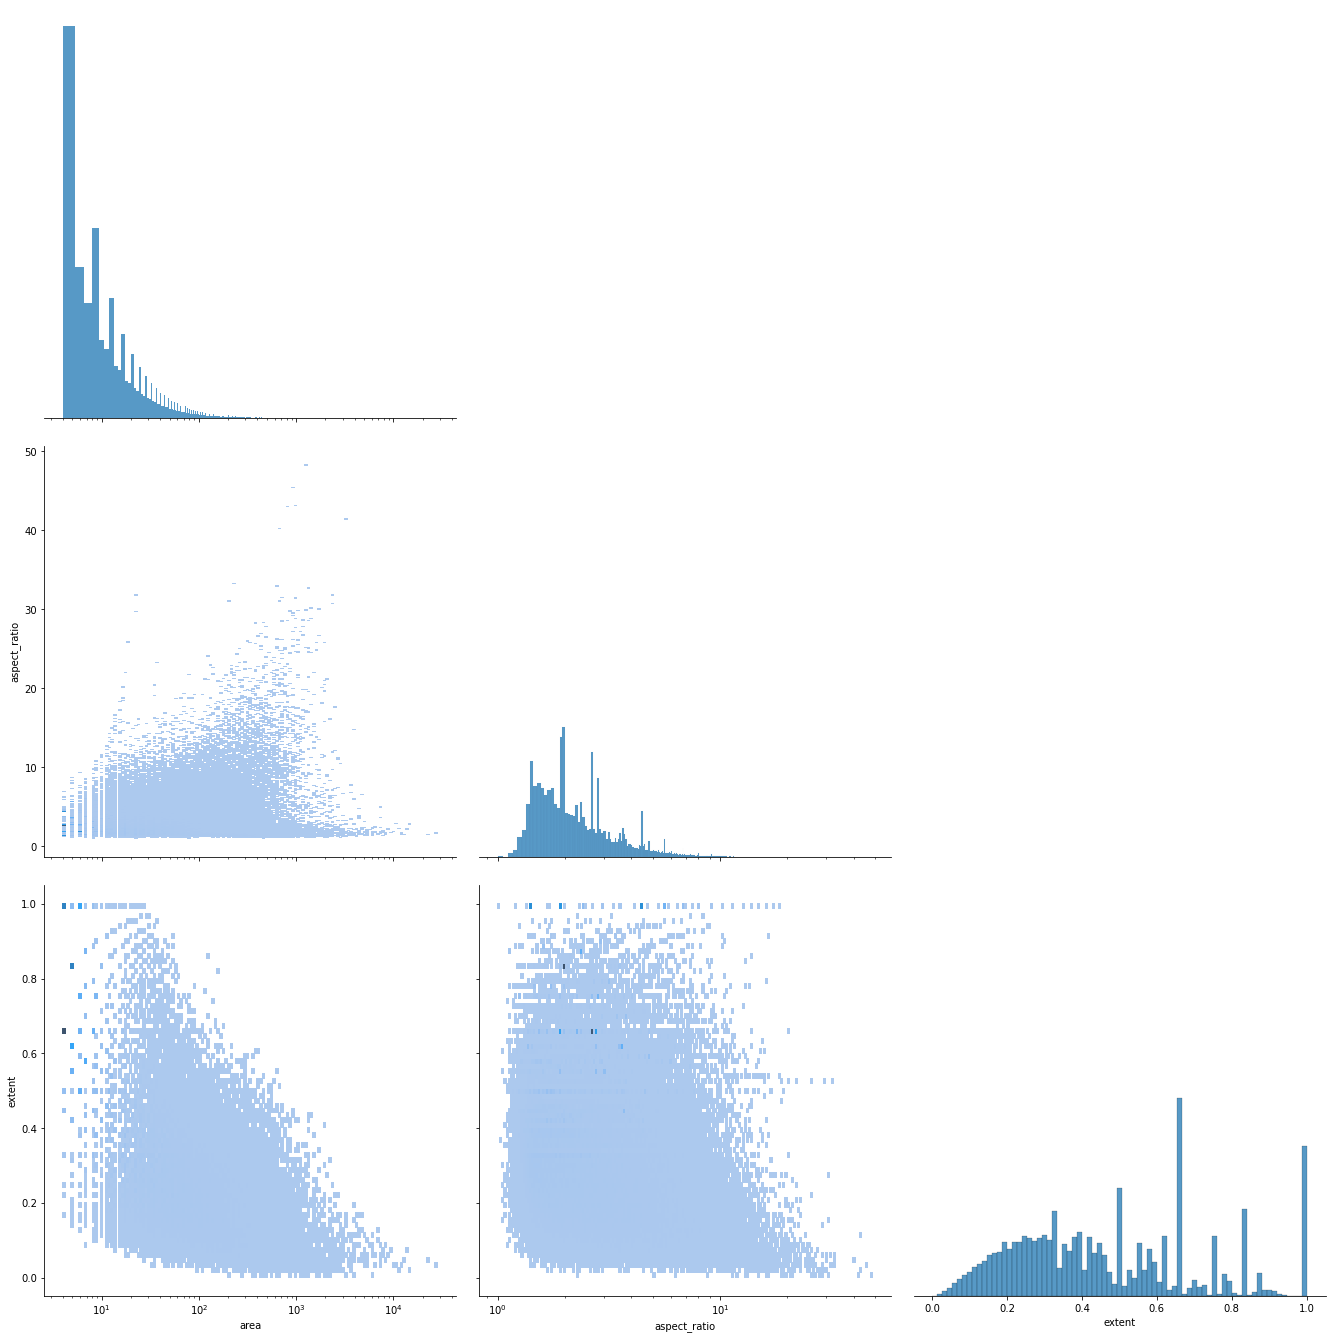

In [22]:
%%time
n = None
df = blobsdf[~blacklist]
df = df.iloc[:n] if n is not None else df

pairgrid = sns.pairplot(
    df,
    vars=["area", "aspect_ratio", "extent"],
    diag_kind="hist",
    diag_kws=dict(log_scale=False),
    kind="hist",
    plot_kws=dict(log_scale=(True, False), palette="inferno"),
    corner=True,
)
pairgrid.fig.set_size_inches(*(sz := 20, sz))

# Checking examples

In [31]:
from IPython.display import display

def show(selector):
    global blacklist, blobsdf, cols_no_moments_no_inertia_no_bbox
    select = (~blacklist) & selector
    logger.info(f"Found {int(select.sum())} blobs.")
    display(blobsdf[select][cols_no_moments_no_inertia_no_bbox].T)
    return select

## `extent` == 1

In [50]:
show((blobsdf.extent == 1) & (blobsdf.area > 20));

[2020-11-12::22:33:53.805] tomo2seg :: INFO :: {<ipython-input-31-7b0b09ee121d>:show:006}
Found 12 blobs.



index,54963,69766,69931,173452,218267,222580,247176,250121,250729,257529,262673,262740
label,2,2,2,2,2,2,2,2,2,2,2,2
area,27,24,21,21,21,24,22,21,26,22,24,22
bbox_area,27,24,21,21,21,24,22,21,26,22,24,22
extent,1,1,1,1,1,1,1,1,1,1,1,1
filled_area,27,24,21,21,21,24,22,21,26,22,24,22
centroid-x,345,441,443,891,1111,1130,1232,1245,1248,1276,1298,1298
centroid-y,633,1008,999,676,225,441,835,877,376,853,461,671
centroid-z,823,1089,529,346,1512,1884,893,801,1763,999,142,974
local_centroid-x,1,0.5,1,1,1,0.5,0.5,1,0.5,0.5,1,0.5
local_centroid-y,4,5.5,3,3,3,2.5,5,3,6,5,3.5,5


## `extent` close to zero

In [45]:
threshold = .012
show((blobsdf.extent < threshold));

[2020-11-12::22:32:38.454] tomo2seg :: INFO :: {<ipython-input-31-7b0b09ee121d>:show:006}
Found 15 blobs.



index,0,110,4002,10282,10809,24044,27125,29147,130125,215975,224003,228959,229211,229578,232535
label,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
area,3991,1930,2009,1627,503,3182,1995,686,6204,1167,204,1743,1300,278,2183
bbox_area,5475800,175560,221487,140244,44132,756756,373756,101525,694848,114000,18975,162864,186620,30912,195650
extent,0.0007286,0.010994,0.00907,0.011604,0.0114,0.004204,0.005337,0.006756,0.00893,0.01024,0.01075,0.010704,0.006966,0.008995,0.011154
filled_area,3991,1930,2009,1627,503,3182,1995,686,6204,1167,204,1743,1300,278,2183
centroid-x,4,8,34,75,72,164,182,190,722,1106,1148,1169,1172,1173,1188
centroid-y,27,534,455,91,406,674,240,139,738,70,464,759,840,249,553
centroid-z,637,643,958,426,913,195,456,815,1540,1870,1088,1879,1541,1882,1406
local_centroid-x,4.555,8.53,10.06,12.7,6.75,18.98,18.86,13.79,34.56,6.89,12.31,11.62,13.52,13.16,15.016
local_centroid-y,27.67,89.1,97.8,73,41.56,132,78.25,66.06,71,49.7,39.47,94.3,97.6,27.05,114.25


## high `aspect_ratio` 

In [34]:
threshold = 30
show((blobsdf.aspect_ratio > threshold));

[2020-11-12::22:29:39.312] tomo2seg :: INFO :: {<ipython-input-31-7b0b09ee121d>:show:006}
Found 18 blobs.



index,1903,4664,24044,29147,161218,163890,199478,213772,220998,229211,234800,238594,245022,249520,252085,254862,258021,258920
label,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
area,2374,646,3182,686,837,652,205,702,237,1300,2319,974,23,992,913,1676,1323,1409
bbox_area,62244,9864,756756,101525,59488,13490,756,20460,7040,186620,14630,9050,44,17640,30408,86240,28485,30855
extent,0.03815,0.0655,0.004204,0.006756,0.01407,0.04834,0.2712,0.0343,0.03366,0.006966,0.1586,0.1076,0.523,0.05624,0.03003,0.01944,0.04645,0.04565
filled_area,2374,646,3182,686,837,652,205,702,237,1300,2319,974,23,992,913,1676,1323,1409
centroid-x,15,30,164,190,830,842,1022,1095,1127,1172,1187,1199,1225,1246,1258,1273,1281,1285
centroid-y,861,593,674,139,930,691,629,807,296,840,287,969,493,351,279,685,897,770
centroid-z,553,153,195,815,1841,1528,567,1722,708,1541,1833,1834,958,1799,859,776,633,1271
local_centroid-x,5.12,2.246,18.98,13.79,4.55,1.46,0.654,6.67,4.195,13.52,4.082,1.339,0.9565,3.904,5.22,9.055,4.168,4.15
local_centroid-y,137.5,72.56,132,66.06,75.56,72.44,33.25,60.44,44.34,97.6,108.8,109.8,10.22,74.75,85,101.44,117.3,76.25


## big `area` 

In [40]:
threshold = 8 * 10**3
show((blobsdf.area > threshold));

[2020-11-12::22:32:00.266] tomo2seg :: INFO :: {<ipython-input-31-7b0b09ee121d>:show:006}
Found 14 blobs.



index,93676,95273,97589,98926,102613,103017,106847,108064,112762,113126,113435,118294,121744,132386
label,2,2,2,2,2,2,2,2,2,2,2,2,2,2
area,22728,9833,8317,11911,11537,8863,28333,13567,9238,14756,8263,12203,12856,10657
bbox_area,446832,258552,175104,349888,455715,155610,711048,197456,131440,569546,100320,325215,302956,267388
extent,0.05087,0.03802,0.0475,0.03403,0.02531,0.05695,0.03986,0.0687,0.0703,0.02591,0.08234,0.03754,0.04245,0.03986
filled_area,22728,9833,8317,11911,11537,8863,28350,13567,9238,14845,8263,12203,12856,10657
centroid-x,639,615,632,645,663,660,673,667,671,678,668,684,694,720
centroid-y,356,333,420,410,380,979,473,145,869,627,465,826,410,520
centroid-z,703,342,1155,671,381,1479,664,593,1621,1512,1438,82,1800,627
local_centroid-x,60.34,28.5,34.4,40.94,43.94,40.03,40.22,30.06,22.81,29.52,17.9,24.02,26.11,25.92
local_centroid-y,50.28,40.53,28.92,46.6,43.25,19.5,37.62,43.53,29.22,46.62,26.14,39.03,42.84,52.06


# Inertia

In [58]:
for i in range(3):
    blobsdf[f"relative_inertia_tensor-{i}-{i}"] = blobsdf[f"inertia_tensor-{i}-{i}"] / blobsdf["area"]

CPU times: user 3.33 s, sys: 316 ms, total: 3.65 s
Wall time: 3.66 s


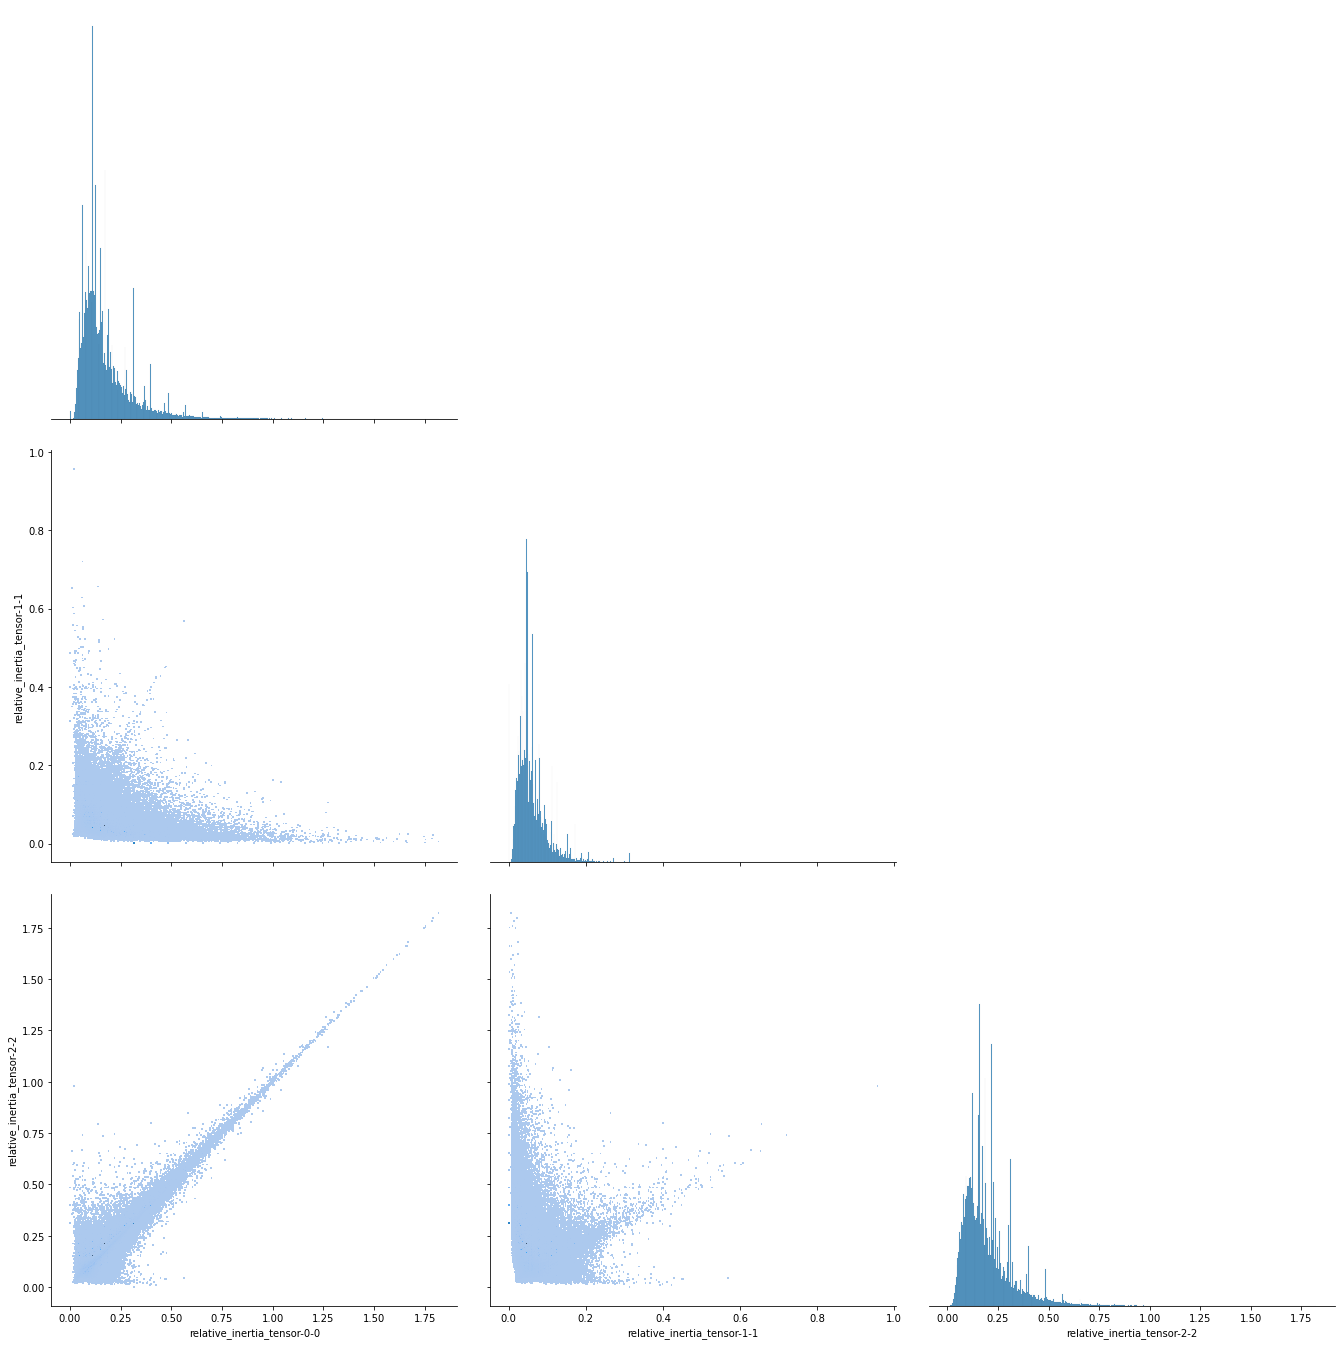

In [59]:
%%time
n = None
df = blobsdf[~blacklist]
df = df.iloc[:n] if n is not None else df
df = df.replace([np.inf, -np.inf], np.nan).dropna()

pairgrid = sns.pairplot(
    df,
#     vars=["inertia_tensor-0-0", "inertia_tensor-1-1", "inertia_tensor-2-2"],
    vars=["relative_inertia_tensor-0-0", "relative_inertia_tensor-1-1", "relative_inertia_tensor-2-2"],
    diag_kind="hist",
    diag_kws=dict(log_scale=False),
    kind="hist",
    plot_kws=dict(log_scale=(False, False), palette="inferno"),
    corner=True,
)
pairgrid.fig.set_size_inches(*(sz := 20, sz))

## High values on each axis

In [69]:
show(
    (blobsdf["relative_inertia_tensor-0-0"] > 1.75) | (blobsdf["relative_inertia_tensor-1-1"] > .7)
);

[2020-11-12::22:58:32.672] tomo2seg :: INFO :: {<ipython-input-31-7b0b09ee121d>:show:006}
Found 80 blobs.



index,0,1903,4048,4664,10809,11148,12225,20114,23108,24044,...,252619,253077,253846,254862,255404,256260,257632,258021,258707,260745
label,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
area,3991,2374,390,646,503,651,11,300,137,3182,...,77,209,1500,1676,128,356,1411,1323,91,95
bbox_area,5475800,62244,32400,9864,44132,43010,60,7650,1590,756756,...,966,5100,39390,86240,624,5096,69960,28485,800,1935
extent,0.0007286,0.03815,0.01204,0.0655,0.0114,0.01514,0.1833,0.0392,0.0862,0.004204,...,0.0797,0.041,0.0381,0.01944,0.2051,0.0699,0.02017,0.04645,0.1138,0.0491
filled_area,3991,2374,390,646,503,651,11,300,137,3182,...,77,209,1500,1676,128,356,1411,1323,91,95
centroid-x,4,15,29,30,72,76,78,123,141,164,...,1258,1259,1266,1273,1267,1273,1283,1281,1282,1295
centroid-y,27,861,746,593,406,446,234,857,717,674,...,465,409,649,685,1007,534,414,897,833,424
centroid-z,637,553,1347,153,913,911,1551,1130,169,195,...,219,1751,768,776,1392,1153,26,633,620,528
local_centroid-x,4.555,5.12,5.434,2.246,6.75,8.586,4.637,3.684,2.27,18.98,...,2.727,1.637,5.977,9.055,1.195,2.957,6.793,4.168,1.571,6.453
local_centroid-y,27.67,137.5,54.03,72.56,41.56,55.7,0.5454,39.47,25.48,132,...,23.48,32.6,90.06,101.44,25.66,36.06,116.25,117.3,26.34,19.89
